<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font size='5' face='verdana' color='black'><b>Deploy a custom model to Watson Machine Learning using scikit-learn</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
</table>

This notebook demonstrates how to deploy a custom model that uses a non-supported framework to `Watson Machine Learning (WML)` using a `scikit-learn estimator`. For supported model types (frameworks), refer to this <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/pm_service_supported_frameworks.html" target="_blank" rel="noopener no referrer">link</a>.

You will learn how to write a `scikit-learn custom estimator` to deploy the model from the <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/1835c567cd309d54fc797900f79a60f9" target="_blank" rel="noopener no referrer">Use statsmodels to forecast the Consumer Price Index (time series)</a> notebook to `Watson Machine Learning (WML)`, specifically, your deployment space. You can find the original notebook in the <a href="https://dataplatform.cloud.ibm.com/gallery" target="_blank" rel="noopener no referrer">Watson Studio Gallery</a>.

The data set, <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626" target="_blank" rel="noopener no referrer">Consumer Prices</a>, which is originally sourced from the <a href="http://www.ilo.org/stat/" target="_blank" rel="noopener no referrer">International Labour Organization</a> measures the Consumer Price Index of different countries over a period of time. The **Consumer Price Index (CPI)** is defined as a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. Forecasting this value is useful because it's a valuable economic indicator used to predict the rate of inflation. It also affects decision making pertaining to income payments.

This notebook uses Python 3.6, the `statsmodels`, and the `watson-machine-learning-client` packages.

## Learning goals
- Load data as a dataframe
    - Create a time series object
- Explore data
    - Check the stationarity of the time series
        - Seasonal decomposition
        - Dicky-Fuller test
- Prepare data - stationarizing the series
- Optimize the ARIMA parameters and create the model
    - ACF and PACF plots to identify parameters
    - Use grid search for ARIMA
- Train the model
- Save the custom model
- Deploy the model
- Score the deployed model

## Contents
1. [Load data](#load)
2. [Explore data](#explore)
3. [Prepare data](#prepare)
4. [Model selection](#modelselection)
5. [Save the custom model in the deployment space](#savemodel)
6. [Deploy the model in the deployment space](#deploy)
7. [Score the model](#score)
8. [Summary and next steps](#summary)

To get started on CP4D 3.0, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener no referrer">here</a>.

<a id="load"></a>
## 1. Load data 

In this section, you will load the time series data as a dataframe and modify it so that the index is a datetime variable.

The data set contains records of the Consumer Price Indices (CPI) of various countries over time, from 1969 to 2008.

First, install the packages required for interacting with data and modeling. The `wget` package will be used to download the data set.

In [ ]:
# Install packages.
!pip install scikit-learn==0.22.1
!pip install pmdarima
!pip install --upgrade wget

Download the <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626" target="_blank" rel="noopener no referrer">Consumer Prices</a> from the <a href="https://dataplatform.cloud.ibm.com/gallery" target="_blank" rel="noopener no referrer">Gallery</a> using the following code.

In [2]:
# Download the data set.
import wget
import os

price_data = 'Consumer prices.csv' 

if not os.path.isfile(price_data):
    link_to_data = 'https://api.dataplatform.cloud.ibm.com/v2/gallery-assets/entries/304ff4a1704b967dd29693a4d32ba626/data?accessKey=d1bec8d606656afaa378d73205c1e649'
    price_data = wget.download(link_to_data)

print(price_data)

Consumer prices.csv


In [3]:
# Load the data as a dataframe
import pandas as pd
import datetime

dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y')
consumer_prices = pd.read_csv(price_data, parse_dates=['Year'], index_col = 'Year', date_parser=dateparse, engine='python')
consumer_prices.head()

,Country or Area,Scope,Value,Value Footnotes
Year,,,,
1991-01-01,Afghanistan,Kabul,143.826616,"1,2"
1990-01-01,Afghanistan,Kabul,100.000000,"1,2"
1989-01-01,Afghanistan,Kabul,67.863097,"1,2"
1988-01-01,Afghanistan,Kabul,39.580269,"1,2"
1987-01-01,Afghanistan,Kabul,31.038541,"1,2"


Before the data set is loaded as a dataframe, the *Year* column is converted into a datetime type variable. Each date is unique, which allows the *Year* column to be made the index of the data set so that the dataframe can be used as a time series object.

Now, when you list the dataframe information, you can see the `DatatimeIndex` and the rest of the columns in the data set. The *Value* column represents the value of the country's Consumer Price Index that year.

In [4]:
consumer_prices.tail()

,Country or Area,Scope,Value,Value Footnotes
Year,,,,
1973-01-01,Zimbabwe,Low income group,14.395168,1
1972-01-01,Zimbabwe,Low income group,13.961438,1
1971-01-01,Zimbabwe,Low income group,13.574597,1
1970-01-01,Zimbabwe,Low income group,13.176034,1
1969-01-01,Zimbabwe,Low income group,12.906417,1


You can see basic information about each column here.

In [5]:
consumer_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7187 entries, 1991-01-01 to 1969-01-01
Data columns (total 4 columns):
Country or Area    7187 non-null object
Scope              7187 non-null object
Value              7187 non-null float64
Value Footnotes    3547 non-null object
dtypes: float64(1), object(3)
memory usage: 280.7+ KB


You can print the number of distinct values that each column has using the following code.

In [6]:
# Distribution of columns.
with pd.option_context('display.max_rows', None):
    for col in consumer_prices:
        print(col, len(consumer_prices[col].value_counts()))

Country or Area 216
Scope 98
Value 6839
Value Footnotes 257


Import the necessary data visualization packages and plot the time series object to observe the several plotted values by country.

In [7]:
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
register_matplotlib_converters()

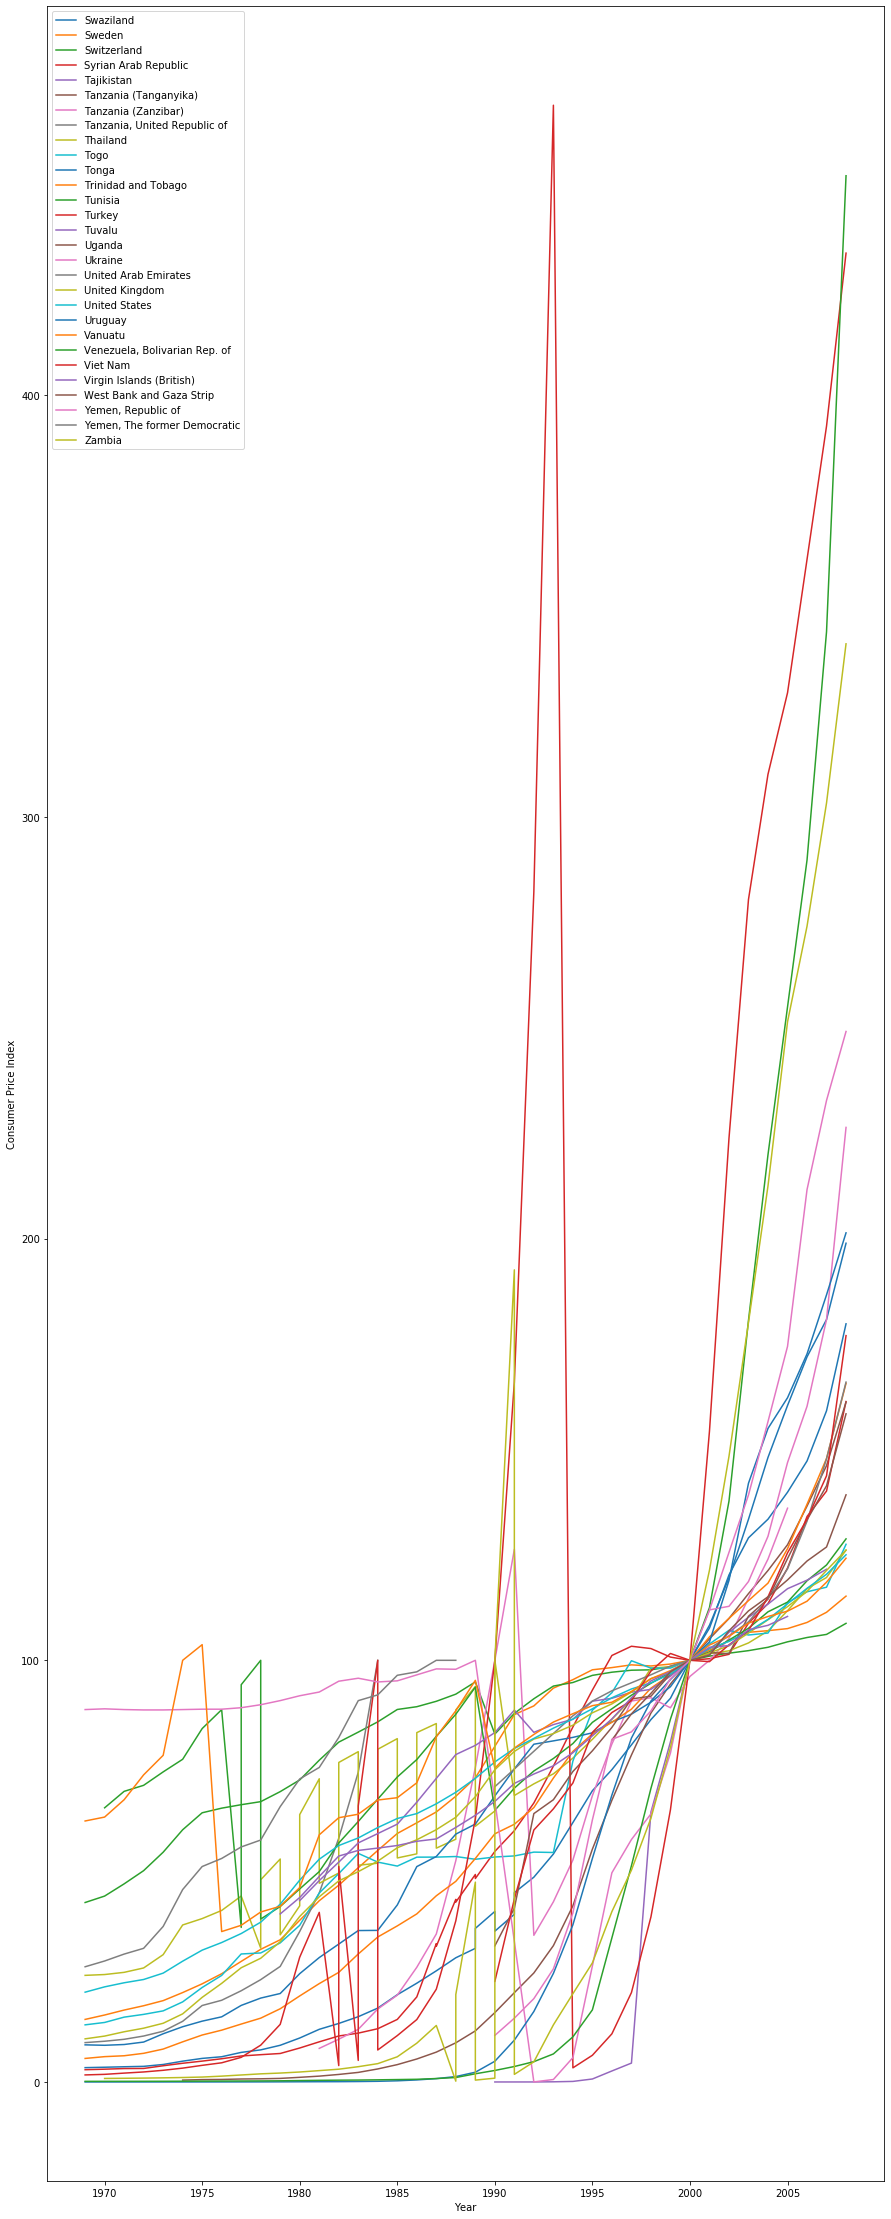

In [8]:
# Plot the data by country.
plt.figure(figsize=(15, 40))
for country in (consumer_prices['Country or Area'].unique()[-30:-1]):    
    plt.plot(consumer_prices.loc[(consumer_prices['Country or Area'] == country)].index.to_pydatetime(), consumer_prices['Value'].loc[consumer_prices['Country or Area'] == country], label=country)
    plt.xlabel('Year')
    plt.ylabel('Consumer Price Index')
    plt.legend()

First, filter the data to obtain the CPI values for the United States. You can then observe the pattern of the values changing over time (1969-2008) in the country.

In [9]:
# CPI values in the United States.
us_consumer_prices = consumer_prices[['Value']].loc[consumer_prices['Country or Area'] == 'United States']
us_consumer_prices = us_consumer_prices.sort_index()
us_consumer_prices.head()

,Value
Year,
1969-01-01,21.293935
1970-01-01,22.554505
1971-01-01,23.524174
1972-01-01,24.299910
1973-01-01,25.812594


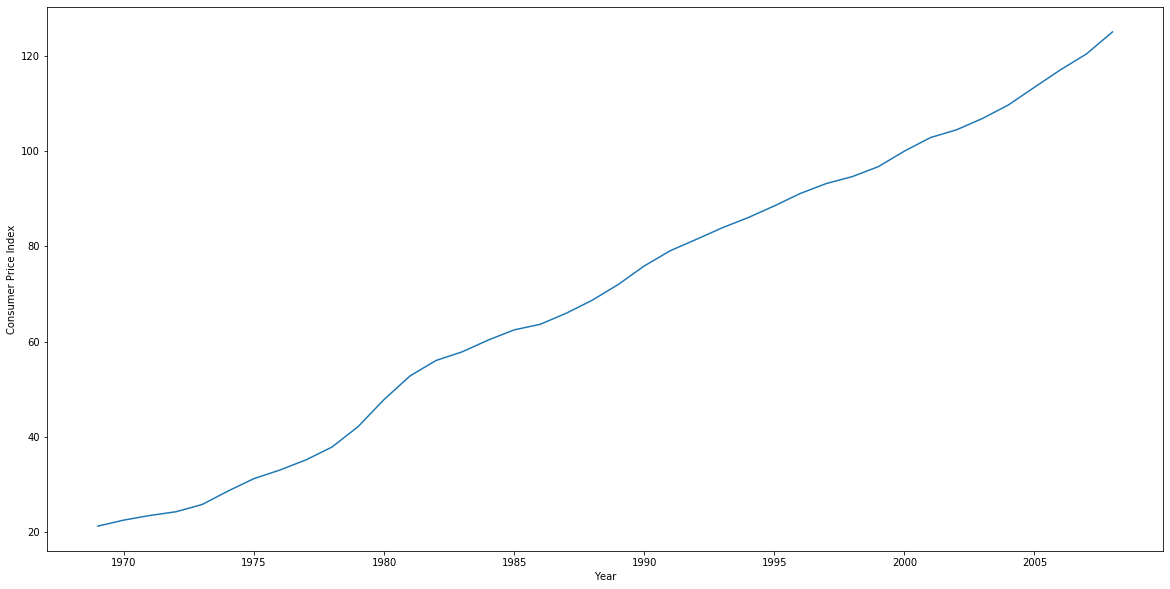

In [10]:
# Plot time series data.
import matplotlib.dates as mdates
plt.figure(figsize=(20, 10))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')
plt.plot(us_consumer_prices.index.to_pydatetime(), us_consumer_prices['Value']);

<a id="explore"></a>
## 2. Explore data

In this section, you will explore the data to learn more about the stationarity of the series and determine the steps to take for data preparation.

### 2.1 Checking stationarity of time series

Check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

#### Seasonal Decomposition

You will use the `statsmodels` package to plot and model the time series data.

Decompose the time series to observe the trend and seasonality in the data.

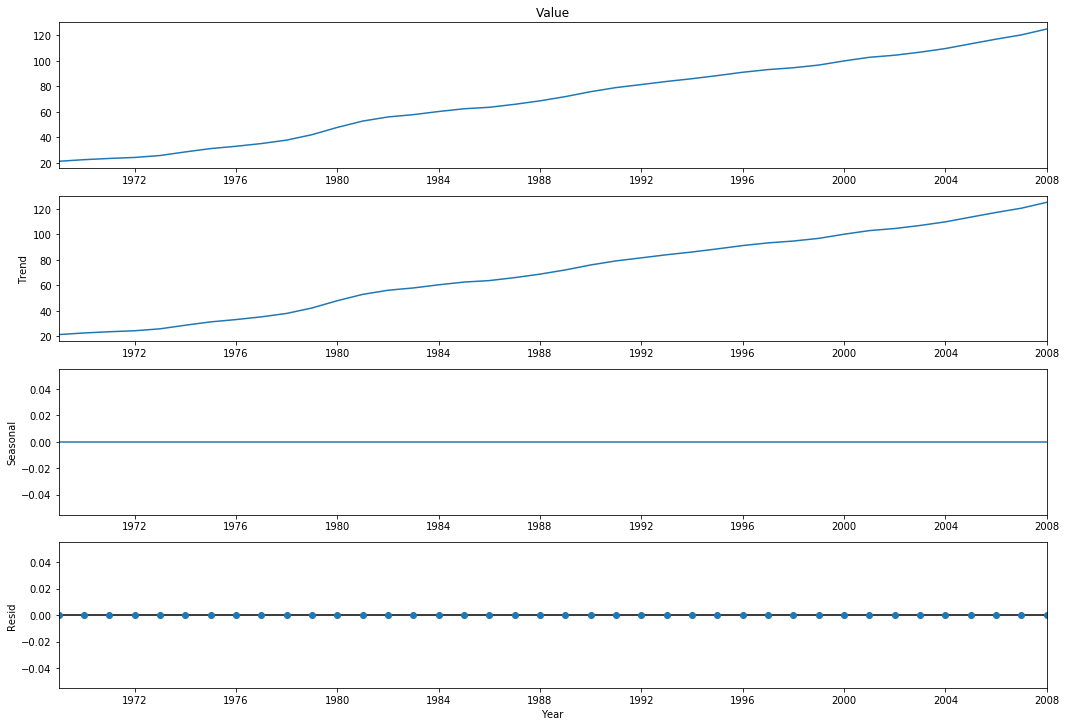

In [11]:
# Decomposition of the time series data.
import numpy
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices['Value'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

As you can see, the trend is changing based on time, so you can infer that the series is not stationary. You can also use another method, called the Dicky-Fuller test, to confirm this observation.

#### Dicky-Fuller Test

In [12]:
# Augmented Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(us_consumer_prices['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  0.640969
p-value                         0.988583
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


You can use the Dicky-Fuller test to check the stationarity of the time series data.

The null hypothesis $H_{o}$ assumes that the time series is dependent on time (that it is non-stationary). Since the `Test Statistic` is larger than the `Critical Values`, we cannot reject the null hypothesis and understand that the series is **non-stationary**.

<a id="prepare"></a>
## 3. Prepare data

### 3.1 ACF & PACF plots

A common tool used to forecast time series data is the `ARIMA` (**A**uto **R**egressive **I**ntegrated **M**oving **A**verage) model. The model has 3 parameters 
- `p` - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the **PACF (partial autocorrelation function)** plot to find the optimal value.
- `d` - the parameter associated with the Integration part of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.
- `q` - the parameter associated with the Moving Average part of the ARIMA model. You can use the **ACF (autocorrelation function)** plot to find the optimal value.

Here are the ACF and PACF plots of the original time series data.

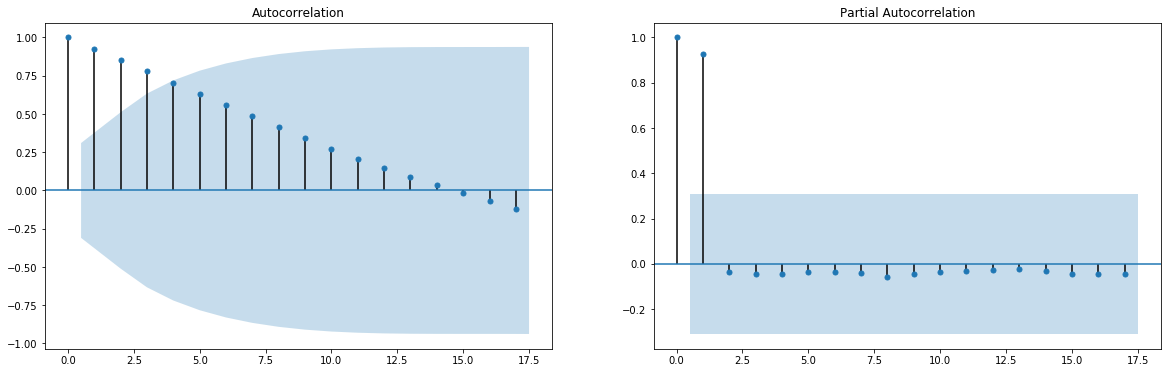

In [13]:
# Visualize the ACF and PACF plots.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(us_consumer_prices['Value'], ax = ax1)
plot_pacf(us_consumer_prices['Value'], ax = ax2, method='ywmle')
plt.show()

Since the series is not stationary, you will first use differencing before finding the parameters for the model.

### 3.2 Stationarizing the time series data

**Differencing** is used to remove the non-stationarity caused by the trend. The number of differences needed to remove stationarity determines the parameter `d`, for the Integration component of the ARIMA model. Run the following code to difference the data twice and plot the resulting values.

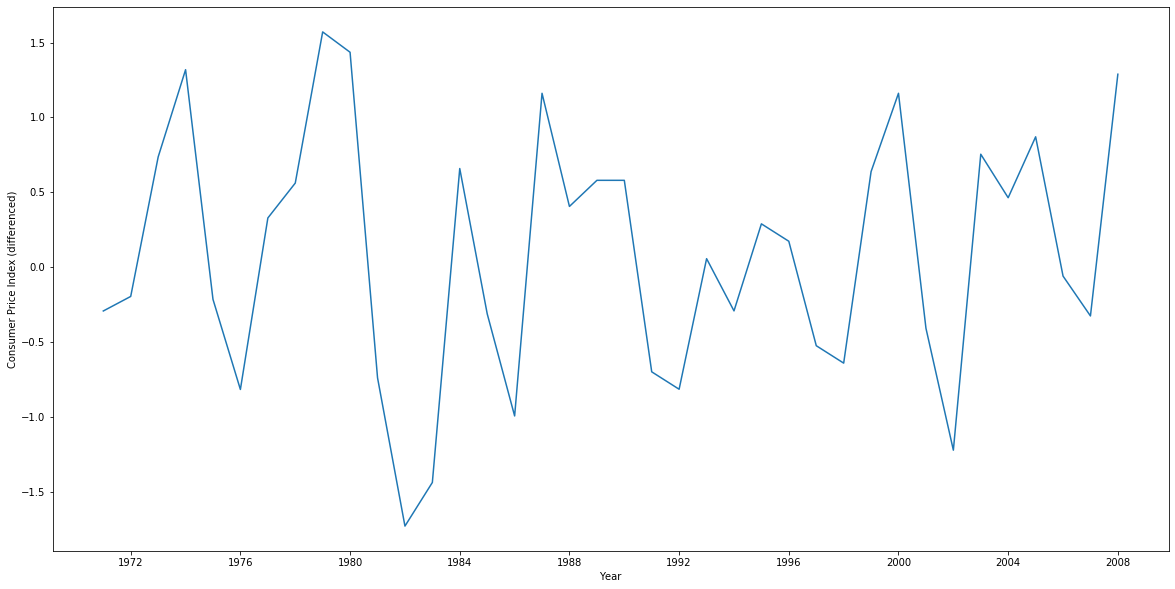

In [14]:
# Differencing - remove non-stationarity.
plt.figure(figsize=(20, 10))
us_consumer_prices_dif = (((us_consumer_prices.diff()).dropna()).diff()).dropna()

plt.xlabel('Year')
plt.ylabel('Consumer Price Index (differenced)')
plt.plot(us_consumer_prices_dif['Value']);

The time series data has been differenced twice to remove stationarity. You can observe the trend of the modified data using the seasonal decomposition method once again.

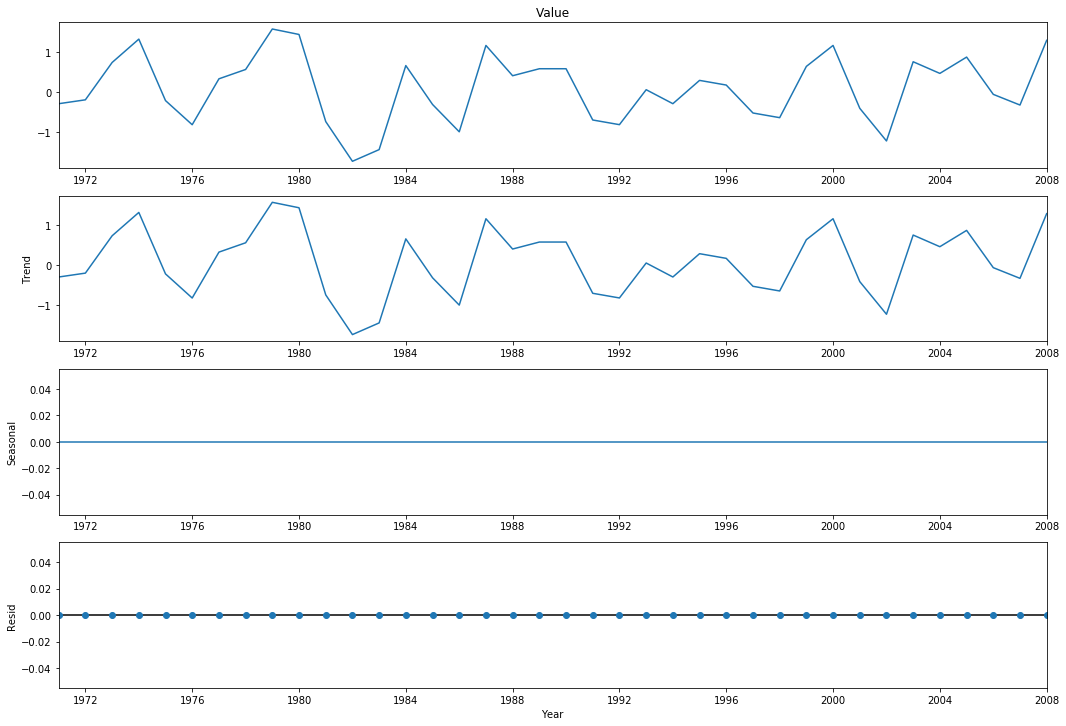

In [15]:
# Decomposition of stationarized time series.
rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices_dif['Value'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

From the plot, you can see that there is no observable trend or seasonality in the differenced time series data. Once again, you can use the Augmented Dicky-Fuller test to confirm that the stationarity of the data as well.

In [16]:
# Augmented Dicky-Fuller test.
dftest = adfuller(us_consumer_prices_dif['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -5.709087e+00
p-value                        7.370726e-07
Number of Lags Used            1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


Since the `Test Statistic` here is less than the `Critical Values`, we can reject the null hypothesis and we can assume that the series is stationary. As you can see from the decomposition plot and the Dicky-Fuller test, the stationarity has been removed.

<a id="modelselection"></a>
## 4. Model Selection

Now, you can run the code below to plot the ACF and PACF plots of the modified stationary data.

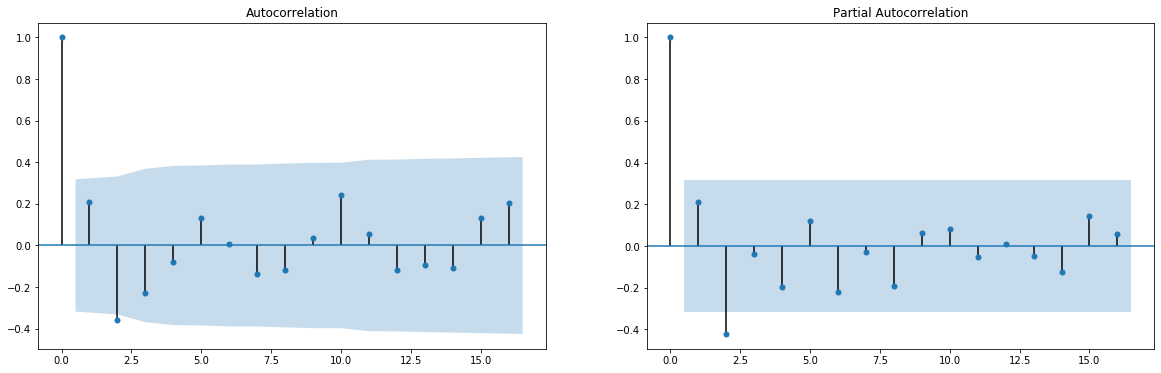

In [17]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
plot_acf(us_consumer_prices_dif['Value'], ax = ax1)
plot_pacf(us_consumer_prices_dif['Value'], ax = ax2, method='ywmle')
plt.show()

### 4.1 Grid Search

To check the optimal values for the ARIMA parameters, you can perform grid search using the package below.

In [18]:
# Import auto-arima - grid search for ARIMA.
from pmdarima.arima import auto_arima

Run the following code to compare the various combinations of the ARIMA parameters, as well as the seasonal parameters.

In [19]:
# Perform grid search for the ARIMA model.
stepwise_model = auto_arima(us_consumer_prices[:'2000'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=2, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=78.442, BIC=81.245, Time=0.029 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=77.673, BIC=81.876, Time=0.032 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=71.611, BIC=75.815, Time=0.040 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=76.631, BIC=78.032, Time=0.014 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=72.600, BIC=78.205, Time=0.060 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=71.605, BIC=77.209, Time=0.128 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=69.085, BIC=76.091, Time=0.407 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=70.048, BIC=77.054, Time=0.587 seconds
Near non-invertible roots for order (0, 2, 3)(0, 0, 0, 0); setting score to inf (at least one 

The parameter set with the lowest `AIC` value (criteria that measures the model) is a good choice to fit the model. The model of `order = (0, 2, 1)` found from the ACF and PACF plots has a minimum AIC value of 71.6. As you can see, however, the lowest AIC value is only slightly better at about 69.1, so you can choose the optimal parameters of `order = (0, 2, 1)`.

### 4.2 Install the custom scikit-learn estimator <a id="custom"></a>

The `scikit-learn custom estimator` that wraps the `statsmodels` model looks like the following and is included in `sklearn_arima-0.1.zip` file that will be downloaded in this subsection.

Download the packaged `custom estimator` package.

In [20]:
filename = 'sklearn_arima-0.1.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/IBMDataScience/sample-notebooks/raw/master/Files/sklearn_arima-0.1.zip')
    
print(filename)

sklearn_arima-0.1.zip


Install the downloaded `custom estimator` package that is compressed in `.zip` format using the `pip install` command.

In [ ]:
!pip install sklearn_arima-0.1.zip

### 4.3 Build the model <a id="build"></a>

Import required modules. The `SklearnArima` module is the `custom estimator` you installed locally in section [4.2 Install the custom scikit-learn estimator](#custom).

A `scikit-learn` pipeline consists of `transformer(s)` and a final `estimator`. You can check the details of the `scikit-learn` pipeline <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline" target="_blank" rel="noopener no referrer">here</a>.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn_arima.arima import SklearnArima

In [23]:
pipeline = Pipeline(
    [
        ('arima', SklearnArima(us_consumer_prices[:'2000'], order=(0, 2, 1)))
    ]
)

Train the model.

In [24]:
pipeline.fit(us_consumer_prices[:'2000'])

Pipeline(memory=None,
         steps=[('arima',
                 SklearnArima(X=                 Value
1969-01-01   21.293935
1970-01-01   22.554505
1971-01-01   23.524174
1972-01-01   24.299910
1973-01-01   25.812594
1974-01-01   28.644028
1975-01-01   31.262134
1976-01-01   33.065719
1977-01-01   35.198991
1978-01-01   37.894672
1979-01-01   42.161216
1980-01-01   47.862871
1981-01-01   52.827577
1982-01-01   56.066272
1983-01-01   57.869857
1984-01-...
1985-01-01   62.485482
1986-01-01   63.646922
1987-01-01   65.969803
1988-01-01   68.699187
1989-01-01   72.009292
1990-01-01   75.900116
1991-01-01   79.094077
1992-01-01   81.475029
1993-01-01   83.914053
1994-01-01   86.062718
1995-01-01   88.501742
1996-01-01   91.114983
1997-01-01   93.205575
1998-01-01   94.657375
1999-01-01   96.747967
2000-01-01  100.000000,
                              alpha=0.05, order=(0, 2, 1), steps=8))],
         verbose=False)

Test the model.

- The first array is the out of sample forecasts.
- The second array is the standard error of the forecasts.
- The third array is a 2D array of the confidence interval for the forecast.

Refer to this <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast" target="_blank" rel="noopener no referrer">link</a> on the return values of the `predict` method.

In [25]:
pipeline.predict(us_consumer_prices[:'2000'])

(array([103.61841519, 107.30849956, 111.07025313, 114.90367589,
        118.80876783, 122.78552896, 126.83395929, 130.9540588 ]),
 array([ 0.71236753,  2.08408232,  3.82279395,  5.86723868,  8.17811507,
        10.72804463, 13.49661345, 16.46786035]),
 array([[102.22220049, 105.01462988],
        [103.22377328, 111.39322585],
        [103.57771466, 118.5627916 ],
        [103.40409939, 126.40325238],
        [102.77995683, 134.83757883],
        [101.75894787, 143.81211006],
        [100.381083  , 153.28683557],
        [ 98.67764562, 163.23047199]]))

### 4.4 Forecasting <a id="forecast"></a>

Now, that you've built the model, you can use it to predict the Consumer Price Index for years 2001-08 and compare the predictions with the observed numbers. Run the code below to plot the observed values alongside the predicted values with a 95% confidence interval.

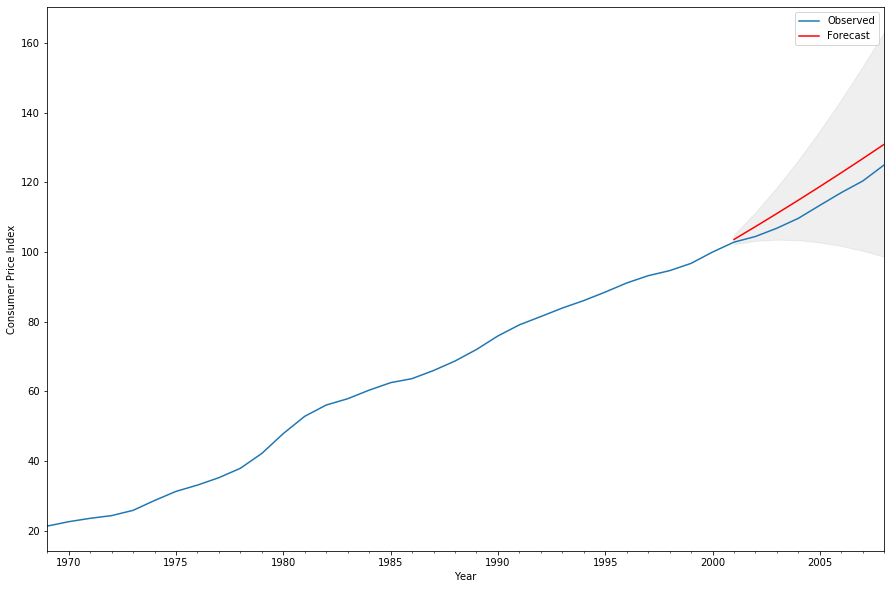

In [26]:
ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast, stderr, conf_int = pipeline.predict(us_consumer_prices[:'2000'])
forecast = pd.DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style = 'r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index, conf_int[:,0], conf_int[:,1], color='dimgray', alpha=0.1)

# Add the labels to the plot.
plt.legend(('Observed', 'Forecast'))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index');

In the plot above, you can observe how the predicted values (in red) measure up to the observed values (in blue) during the years 2001-08.

## 5. Save the custom model in the deployment space <a id="savemodel"></a>

### 5.1 Setting up <a id="setup"></a>

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your CP4D cluster, you do not need to install this package as it comes pre-installed with the notebooks. The installation code below is for demonstration but is non-executable at this stage.
</div>

In [27]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Authenticate the Python client on CP4D 3.0.**<br><br>

<div class="alert alert-block alert-info">To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation.</a></div>

**Action**: Enter your credentials in the following cell.

In [28]:
# Enter your credentials here
import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": url,
"version": "3.0.0"
}

In [29]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### To set the default space, follow these steps.

<div class="alert alert-block alert-info">
You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Analytics deployments</b> under <b>Analyze</b> from the Navigation Menu on the top left of this page.</div>

Alternatively, you can create a deployment and obtain its UID using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [31]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [32]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 219be37a-7417-4bf0-9d8f-584bc3dbc468


You can set the default space using the cell below.

In [33]:
client.set.default_space(space_uid)

'SUCCESS'

### 5.2 Save the custom estimator as a package extension <a id="package_ext"></a>

In this section, you'll use the Python client to save the custom estimator `sklearn_arima-0.1.zip`, a <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener no referrer">custom component</a>, as a package extension.

In [34]:
# Custom estimator
cust_lib_zip_path = "sklearn_arima-0.1.zip"

Create the metadata for the new package extension.

In [35]:
# Package extension metadata
meta_prop_pkg_ext = {
     client.package_extensions.ConfigurationMetaNames.NAME: "sklearn_arima_1",
     client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "ARIMA model for sklearn pipeline",
     client.package_extensions.ConfigurationMetaNames.TYPE: "pip_zip"
}

Store the package extension associated with the custom estimator.

In [36]:
# Store the package extension
package_ext_details = client.package_extensions.store(meta_props=meta_prop_pkg_ext,file_path=cust_lib_zip_path)

Creating package extensions
SUCCESS


In [37]:
package_ext_details

{'metadata': {'space_id': '219be37a-7417-4bf0-9d8f-584bc3dbc468',
  'name': 'sklearn_arima_1',
  'asset_id': '410596e1-8ea3-4929-a34e-a08449b94ac6',
  'asset_type': 'package_extension',
  'created_at': '2020-05-05T02:06:34Z'},
 'entity': {'package_extension': {'type': 'pip_zip',
   'href': '/v2/asset_files/package_extension/sklearn_arima_1_p1DxnSn3XZ.zip?space_id=219be37a-7417-4bf0-9d8f-584bc3dbc468&signature=xDgtpT0W20hWCQjk%2BEME0A%3D%3D%3ADSECeRUb1q3%2B2o%2F%2Brnyqg1WpL8cNq8%2BtFo6T9FMcetvACyh0v04Lu6eO6O13vd3%2FrZJD%2B83N9FaFvpWaid8J6FDWRxwW7BW4QLQPQ%2Fe1H9mzUqEWwbwkFvELQVOEzDbso8tWVMVXv2dGt%2BjA3lUTHnIZx6rIjCUpiebaNR7V5Xv3Jx4q5Wk%2BU%2BI1CLo3k6I%2Fogcn4pXegLA0thcwx59vEbQ5W72ealPLjr1u'}}}

You can list the available package extensions with the following code.

In [38]:
# List all package extensions
client.package_extensions.list()

---------------  ------------------------------------  -------  --------------------
NAME             ASSET_ID                              TYPE     CREATED_AT
sklearn_arima_1  410596e1-8ea3-4929-a34e-a08449b94ac6  pip_zip  2020-05-05T02:06:34Z
---------------  ------------------------------------  -------  --------------------


<div class="alert alert-block alert-info">
From the list of package extensions, you can see that the custom estimator is successfully saved.</div>

Get the UID of the package extension.

In [39]:
# Obtain package extension UID
package_ext_uid = client.package_extensions.get_uid(package_ext_details)
print('Package extension UID = {}'.format(package_ext_uid))

Package extension UID = 410596e1-8ea3-4929-a34e-a08449b94ac6


### 5.3 Create the associated software specification <a id="sw_spec"></a>

In this section, you'll use the Python client to create a custom software specification and add the package extension containing the custom estimator. This will be used to configure the online deployment environment for the model.

Create the metadata for your custom software specification to associate the previous package extension to.

In [40]:
# Software specification metadata.
base_software_spec_uid = client.software_specifications.get_uid_by_name('scikit-learn_0.22-py3.6')

meta_prop_sw_spec = {
     client.software_specifications.ConfigurationMetaNames.NAME: "sklearn_arima_model",
     client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "scikit-learn ARIMA model",
     client.software_specifications.ConfigurationMetaNames.PACKAGE_EXTENSIONS : [{
         "guid": package_ext_uid
     }],
     client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {
         "guid": base_software_spec_uid
     }
}

Store the custom software specification.

In [41]:
# Store software specification
software_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)
software_spec_details

{'metadata': {'created_at': '2020-05-05T02:06:39Z',
  'name': 'sklearn_arima_model',
  'description': 'scikit-learn ARIMA model',
  'asset_id': 'ca125a99-ea1b-41f1-9d79-35707917ecd1',
  'asset_type': 'software_specification',
  'space_id': '219be37a-7417-4bf0-9d8f-584bc3dbc468',
  'href': '/v2/software_specifications/ca125a99-ea1b-41f1-9d79-35707917ecd1'},
 'entity': {'software_specification': {'type': 'derived',
   'display_name': 'sklearn_arima_model',
   'base_software_specification': {'guid': '154010fa-5b3b-4ac1-82af-4d5ee5abbc85',
    'href': '/v2/software_specifications/154010fa-5b3b-4ac1-82af-4d5ee5abbc85'},
   'package_extensions': [],
   'software_configuration': {'included_packages': [{'name': 'scikit-learn',
      'version': '0.22'}],
    'platform': {'name': 'python', 'version': '3.6'}}}}}

<div class="alert alert-block alert-info">
    To list the software specifications, run <tt>client.software_specifications.list()</tt>. You'll see that the custom software specification has been successfully created.<br><br>
    To find more information about creating a custom software specification, or to learn about the available frameworks, <b>Software Specifications</b>, and their respective <b>Types</b>, visit the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html" target="_blank" rel="noopener no referrer">documentation</a>.</div>

In [42]:
client.software_specifications.list()

--------------------------  ------------------------------------  -------
NAME                        ASSET_ID                              TYPE
default_py3.6               0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
scikit-learn_0.20-py3.6     09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
ai-function_0.1-py3.6       0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                  0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6           10ac12d6-6b30-4ccd-8392-3e922c096a92  base
scikit-learn_0.22-py3.6     154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
tensorflow_1.15-py3.6       2b73a275-7cbf-420b-a912-eae7f436e0bc  base
pytorch_1.2-py3.6           2c8ef57d-2687-4b7d-acce-01f94976dac1  base
spark-mllib_2.3             2e51f700-bca0-4b0d-88dc-5c6791338875  base
pytorch-onnx_1.1-py3.6-edt  32983cea-3f32-4400-8965-dde874a8d67e  base
spark-mllib_2.4             390d21f8-e58b-4fac-9c55-d7ceda621326  base
xgb

Get the UID of the new software specification.

In [43]:
# Obtain software specification UID
software_spec_uid = client.software_specifications.get_uid(software_spec_details)
print('New Software Specification UID = {}'.format(software_spec_uid))

New Software Specification UID = ca125a99-ea1b-41f1-9d79-35707917ecd1


Add the package extension containing your custom estimator to the newly created software specification.

In [44]:
# Associate package extension.
client.software_specifications.add_package_extension(software_spec_uid, package_ext_uid)

'SUCCESS'

You can see the details of the custom software specification by running the following code.

In [45]:
client.software_specifications.get_details(software_spec_uid)

{'metadata': {'name': 'sklearn_arima_model',
  'asset_id': 'ca125a99-ea1b-41f1-9d79-35707917ecd1',
  'href': '/v2/software_specifications/ca125a99-ea1b-41f1-9d79-35707917ecd1',
  'asset_type': 'software_specification',
  'created_at': '2020-05-05T02:06:39Z'},
 'entity': {'software_specification': {'type': 'derived',
   'display_name': 'sklearn_arima_model',
   'base_software_specification': {'guid': '154010fa-5b3b-4ac1-82af-4d5ee5abbc85',
    'href': '/v2/software_specifications/154010fa-5b3b-4ac1-82af-4d5ee5abbc85'},
   'package_extensions': [{'metadata': {'rov': {'mode': 0,
       'collaborator_ids': {}},
      'space_id': '219be37a-7417-4bf0-9d8f-584bc3dbc468',
      'usage': {'last_updated_at': '2020-05-05T02:06:36Z',
       'last_updater_id': '1000330999',
       'last_update_time': 1588644396466,
       'last_accessed_at': '2020-05-05T02:06:36Z',
       'last_access_time': 1588644396466,
       'last_accessor_id': '1000330999',
       'access_count': 0},
      'name': 'sklearn_ar

### 5.4 Save the custom scikit-learn estimator <a id="custom_model"></a>

Now, you can create the model metadata with the custom software specification you just created.

In [46]:
meta_props={
     client.repository.ModelMetaNames.NAME: "Custom ARIMA estimator for sklearn pipeline",
     client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
     client.repository.ModelMetaNames.TYPE: "scikit-learn_0.22"
}

You can extract the model UID from the saved model details.

In [47]:
# Save the model
model_artifact = client.repository.store_model(model=pipeline, meta_props=meta_props)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = f9ee027c-af95-478a-8e21-aa6e393db2a1


Print the details of the trained model.

In [48]:
# Details about the model.
from pprint import pprint
pprint(model_artifact)

{'entity': {'content_status': {'state': 'persisted'},
            'name': 'Custom ARIMA estimator for sklearn pipeline',
            'software_spec': {'id': 'ca125a99-ea1b-41f1-9d79-35707917ecd1'},
            'space': {'href': '/v4/spaces/219be37a-7417-4bf0-9d8f-584bc3dbc468',
                      'id': '219be37a-7417-4bf0-9d8f-584bc3dbc468'},
            'type': 'scikit-learn_0.22'},
 'metadata': {'created_at': '2020-05-05T02:06:45.002Z',
              'guid': 'f9ee027c-af95-478a-8e21-aa6e393db2a1',
              'href': '/v4/models/f9ee027c-af95-478a-8e21-aa6e393db2a1?space_id=219be37a-7417-4bf0-9d8f-584bc3dbc468',
              'id': 'f9ee027c-af95-478a-8e21-aa6e393db2a1',
              'modified_at': '2020-05-05T02:06:47.002Z',
              'name': 'Custom ARIMA estimator for sklearn pipeline',
              'owner': '1000330999',
              'space_id': '219be37a-7417-4bf0-9d8f-584bc3dbc468'}}


In [49]:
client.repository.list_models()

------------------------------------  -------------------------------------------  ------------------------  -----------------
GUID                                  NAME                                         CREATED                   TYPE
f9ee027c-af95-478a-8e21-aa6e393db2a1  Custom ARIMA estimator for sklearn pipeline  2020-05-05T02:06:45.002Z  scikit-learn_0.22
------------------------------------  -------------------------------------------  ------------------------  -----------------


<div class="alert alert-block alert-info">
From the list of models, you can see that your model is successfully saved in the deployment space. You can view your model by selecting <b>Analytics Deployments</b> under <b>Analyze</b> from the Navigation Menu and clicking on your deployment space name.</div>

## 5. Deploy the model in the deployment space<a id="deploy"></a>

In this section, you will deploy the model to Watson Machine Learning – you will be able to access this deployed model through the deployment space.

Create the deployment metadata and initiate the deployment.

In [50]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "sklearn_pipeline_arima deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [51]:
# Create the deployment
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: 'f9ee027c-af95-478a-8e21-aa6e393db2a1' started

#######################################################################################


initializing............
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='94c49d68-d59e-43db-9bb3-c8ce684c7301'
------------------------------------------------------------------------------------------------




List the deployments.

In [52]:
# List the deployments.
client.deployments.list()

------------------------------------  ---------------------------------  -----  ------------------------  -------------
GUID                                  NAME                               STATE  CREATED                   ARTIFACT_TYPE
94c49d68-d59e-43db-9bb3-c8ce684c7301  sklearn_pipeline_arima deployment  ready  2020-05-05T02:06:49.771Z  model
------------------------------------  ---------------------------------  -----  ------------------------  -------------


<div class="alert alert-block alert-info">
From the list of deployed models, you can see that the custom model was successfully deployed in the deployment space.</div>

Now, you can check the details of your deployment.

In [53]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment UID: {}'.format(deployment_uid))

Deployment UID: 94c49d68-d59e-43db-9bb3-c8ce684c7301


In [54]:
# Deployment details.
pprint(client.deployments.get_details(deployment_uid))

{'entity': {'asset': {'href': '/v4/models/f9ee027c-af95-478a-8e21-aa6e393db2a1?space_id=219be37a-7417-4bf0-9d8f-584bc3dbc468',
                      'id': 'f9ee027c-af95-478a-8e21-aa6e393db2a1'},
            'custom': {},
            'description': '',
            'name': 'sklearn_pipeline_arima deployment',
            'online': {},
            'space': {'href': '/v4/spaces/219be37a-7417-4bf0-9d8f-584bc3dbc468',
                      'id': '219be37a-7417-4bf0-9d8f-584bc3dbc468'},
            'space_id': '219be37a-7417-4bf0-9d8f-584bc3dbc468',
            'status': {'online_url': {'url': 'https://internal-nginx-svc:12443/v4/deployments/94c49d68-d59e-43db-9bb3-c8ce684c7301/predictions'},
                       'state': 'ready'}},
 'metadata': {'created_at': '2020-05-05T02:06:49.771Z',
              'description': '',
              'guid': '94c49d68-d59e-43db-9bb3-c8ce684c7301',
              'href': '/v4/deployments/94c49d68-d59e-43db-9bb3-c8ce684c7301',
              'id': '94c49d68-d5

## 6. Score the model <a id="score"></a>

### 6.1 Scoring

Prepare sample scoring data.

In [55]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': us_consumer_prices[:'2000'].values.reshape(1, -1).tolist()
    }]
}
pprint(job_payload)

{'input_data': [{'values': [[21.29393521,
                             22.55450514,
                             23.52417432,
                             24.29990967,
                             25.81259359,
                             28.6440276,
                             31.26213438,
                             33.06571906,
                             35.19899126,
                             37.89467158,
                             42.16121597,
                             47.86287075,
                             52.82757696,
                             56.06627202,
                             57.86985670000001,
                             60.33281642,
                             62.485482,
                             63.64692218,
                             65.96980256,
                             68.69918699,
                             72.00929152,
                             75.90011614,
                             79.09407666,
                             81

Get the prediction results of the deployed model.

In [56]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid,
                                           job_payload)
pprint(job_details)

{'predictions': [{'fields': ['prediction'],
                  'values': [[[103.61841518710672,
                               107.30849956368732,
                               111.0702531297418,
                               114.90367588527016,
                               118.8087678302724,
                               122.78552896474852,
                               126.83395928869852,
                               130.9540588021224]],
                             [[0.7123675252174944,
                               2.084082319757026,
                               3.82279395234582,
                               5.867238675830576,
                               8.178115068596716,
                               10.728044626990753,
                               13.4966134544235,
                               16.46786034862888]],
                             [[[102.2222004939245, 105.01462988028894],
                               [103.22377327614686, 111.39322585122778],
  

### 6.2 Forecasting

Plot the same graph in section [4.4 Forecasting](#forecast) to see if the scored results are the same as the one predicted locally.

Prepare data to plot the forecast results.

In [57]:
# The prediction results consist of both the forecasted values and the confidence interval.
predictions = job_details['predictions'][0]['values']
forecast = numpy.array(predictions[0][0])
conf_int = numpy.array(predictions[2][0])
print(forecast)
print(conf_int)

[103.61841519 107.30849956 111.07025313 114.90367589 118.80876783
 122.78552896 126.83395929 130.9540588 ]
[[102.22220049 105.01462988]
 [103.22377328 111.39322585]
 [103.57771466 118.5627916 ]
 [103.40409939 126.40325238]
 [102.77995683 134.83757883]
 [101.75894787 143.81211006]
 [100.381083   153.28683557]
 [ 98.67764562 163.23047199]]


Plot the values forecasted by the deployed model.

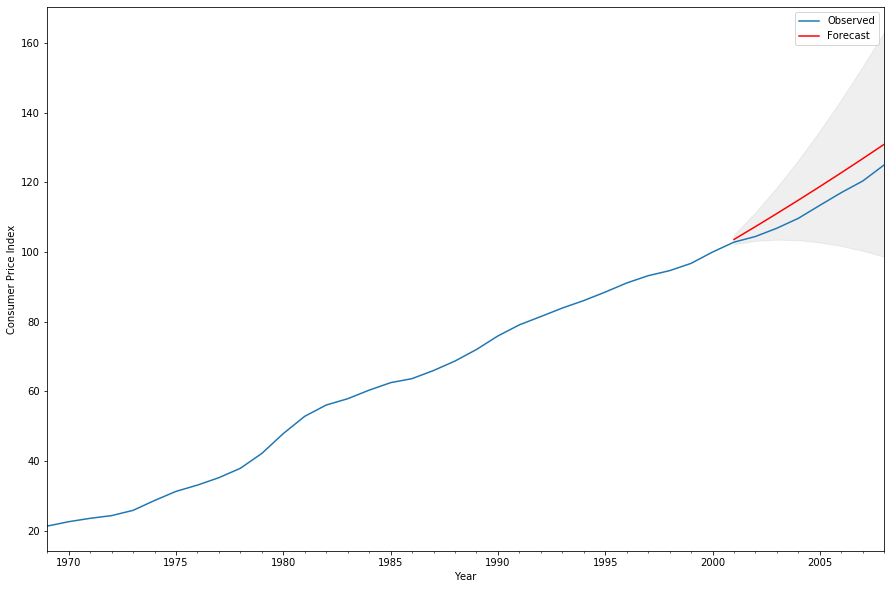

In [58]:
ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast = pd.DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style = 'r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index, conf_int[:,0], conf_int[:,1], color='dimgray', alpha=0.1)

# Add the labels to the plot.
plt.legend(('Observed', 'Forecast'))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index');

The generated graph and the one in section [4.4 Forecasting](#forecast) are the same. As you can see from the predicted and observed values, the time series model built & deployed in this notebook does a good job of predicting the Consumer Price Index in the United States close to the observed numbers.

### 6.3 Delete artifacts

Use the following methods to delete the deployment, model, custom software specification, and package extension if they are no longer needed.

In [59]:
# client.deployments.delete(deployment_uid)

'SUCCESS'

In [60]:
# client.repository.delete(model_uid)

'SUCCESS'

In [61]:
# client.software_specifications.delete(software_spec_uid)

'SUCCESS'

In [62]:
# client.package_extensions.delete(package_ext_uid)

'SUCCESS'

<a id="summary"></a>
## 7. Summary and next steps

You successfully completed this notebook and learned how to create a Time Series model. You can now analyze a time series data to check its stationarity, stationarize the series if necessary, and find the optimal parameters for the ARIMA model. You've learned how to use this model to forecast data with a confidence interval.

You also learned how to deploy a non-supported model using a `custom scikit-learn estimator`. You learned to the `watson-machine-learning-client` to store custom estimator as a package extension to use the same operation with WML. Finally, you stored the custom estimator using a software specification associated with the package extension, so this model could be deployed and scored later using WML.

### Resources 

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:
<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener noreferrer">CP4D 3.0</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener noreferrer">Custom components</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html#creating-a-custom-software-specification-in-a-project" target="_blank" rel="noopener no referrer">Custom software specifications</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://www.tensorflow.org/api_docs/python/tf/py_function" target="_blank" rel="noopener noreferrer">tf.py_function</a></li>
 </div>

### Data citations

UNData: Consumer prices, general indices (2000=100). (2010). Retrieved from [http://data.un.org/](http://data.un.org/Data.aspx?d=LABORSTA&f=tableCode%3a7A).

Consumer Price Index: U.S. Bureau Of Labor Statistics. Retrieved from https://www.bls.gov/cpi/.



### Author

**Ananya Kaushik** is a Data Scientist at IBM.  
**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

<hr>Copyright © 2019, 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>